# Working with a cohort of phenopackets
This notebook illustrates reading in a cohort of phenopackets from a directory and performing basic QA/QC tasks including plotting various parameters and performing simple survival analysis.


In [196]:
import os
import typing
from typing import Optional
import warnings
import pandas as pd
from math import isnan
import re

from collections import Counter    
from google.protobuf.json_format import Parse
from phenopackets import Phenopacket

# plotting parameters
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica' 
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = 'black'


## Load the phenopackets

In [22]:
def _load_phenopacket(phenopacket_path: str) -> Phenopacket:
    with open(phenopacket_path) as f:
        return Parse(f.read(), Phenopacket())

def load_phenopacket_dir(pp_dir: str) -> typing.Sequence[Phenopacket]:
    patients = []
    for patient_file in os.listdir(pp_dir):
        if patient_file.endswith('.json'):
            phenopacket_path = os.path.join(pp_dir, patient_file)
            pp = _load_phenopacket(phenopacket_path)
            patients.append(pp)

    return patients

cohort = "Lung"
fpath_pp_dir = '/Users/sierkml/data/phenopackets/'
fpath_cohort_dir = fpath_pp_dir + cohort

pps = load_phenopacket_dir(fpath_cohort_dir)
print("Loaded", len(pps), "phenopackets from", fpath_cohort_dir)

Loaded 5415 phenopackets from /Users/sierkml/data/phenopackets/Lung


### Define plotting functions

In [197]:
def get_years_from_iso8601duration(iso8601):
    
    # deal with P#Y#M#D format
    # expect, e.g., P55Y6M or P11355D
    # strip P, Y and M
    years, months, days = '', '', ''
    try:
        # get years from P[number]Y
        #years = iso8601.split('Y')[0].split('P')[1]
        #months = iso8601.split('M')[0].split('Y')[1]
        #days = iso8601.split('D')[0].split('')
        
        if re.search('Y', iso8601):
            years = re.split('^P(\d+)Y',iso8601)[1]
        if re.search('M', iso8601):
            months = re.split('^P.*(\d+)M',iso8601)[1]
        if re.search('^P\d+D$', iso8601):
            days = re.split('^P(\d+)D$',iso8601)[1]
        
        years = float(years) if years != '' else 0
        
        if months != '': 
            try:
                years += float(months) / 12
            except TypeError:
                raise Exception(f'Could not parse months: {months}')
        
        if days != '':
            try:
                years += float(days) / 365.25
            except TypeError:
                raise Exception(f'Could not parse days: {days}')
        
    except TypeError:
        raise Exception(f'Could not parse age string: {iso8601}')
    
    return float(years)         

def generate_age_barplot(phenopackets, ax):

    # {
    #   "id": "Lung-GENIE.GENIE-GRCC-fea72025",
    #   "subject": {
    #     "id": "GENIE.GENIE-GRCC-fea72025",
    #     "timeAtLastEncounter": {
    #       "age": {
    #         "iso8601duration": "P24106DT0H0M0S"
    #       }
    #     },
    # make pandas series of ages

    # TODO: change whether timeAtLastEncounter is the only measure of age we get
    
    # TODO: roughly half of patients have no timeAtLastEncounter.age.iso8601duration
    # grep -C2 -w age *json | grep iso8601 | wc -l # 8339
    # wc -l *json # 16467
    
    # # TODO: what if the field is missing/unset? Set `float(nan)`
    # duration = subject.time_at_last_encoutner.age.iso8601duration
    # # TODO - refine
    # age_in_days = 
    # data['age_in_days'].append(pp.subject.id)

    
    ages = []
    for pp in phenopackets:
        # Accessing ages in the subject object in Phenopacket
        age_str = pp.subject.time_at_last_encounter.age.iso8601duration

        try:
            duration = pd.to_timedelta(age_str) # nan if no value in pp
            age_in_years = duration.days / 365.25
            ages.append(age_in_years)
            
        except ValueError:

            warnings.warn(f"Could not parse age string with pandas, using manual approach: {age_str}")
            
            age_in_years = get_years_from_iso8601duration(age_str)
            
            ages.append(float(age_in_years))
    
    tot = sum(1 for x in ages if not isnan(x))
    tot_text = 'Total values:' + str(tot)  
              
    bins = [10,20,30,40,50,60,70,80,90]
    values, bins, bars = ax.hist(ages, bins=bins, rwidth=0.7, color=['purple'])
    ax.set(xlabel='Age', ylabel='Number of Patients')
    ax.set_title('Patient Ages', fontsize=14, weight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.bar_label(bars, fontsize=10)
    ax.text(0.05, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')


In [198]:
def generate_sex_barplot(phenopackets, ax):
    
    male_count = 0
    female_count = 0
    other_count = 0

    for pp in phenopackets:
        # Accessing sex attribute of the subject object in Phenopacket
        sex = pp.subject.sex
        if sex == 2: # 2 = 'MALE' apparently
            male_count += 1
        elif sex == 1: # 1 = 'FEMALE' apparently
            female_count += 1
        else:
            other_count += 1
    
    sexes = ['Male', 'Female', 'Other']
    counts = [male_count, female_count, other_count]
    
    tot = male_count + female_count + other_count
    tot_text = 'Total values:' + str(tot)    
    
    bars = ax.bar(sexes, counts, color=['blue', 'pink', 'gray'])
    ax.set(ylabel='Number of Patients', title='Sex of Patients')
    ax.set_title('Sex of Patients', fontsize=14, weight='bold')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.bar_label(bars, fontsize=10)

    ax.text(0.80, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')


In [199]:
def generate_stages_barplot(phenopackets, ax):
    
    stages = Counter()
    
    for pp in phenopackets:
        # Accessing disease attribute of the subject object in Phenopacket
        for d in pp.diseases:
            if d.disease_stage:
                for s in d.disease_stage:
                    stages[s.label] += 1
                    # AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'label'
                    # stages[d.disease_stage.label] += 1

    # df = pd.DataFrame(stages.items(), columns=['stage', 'count'])
    stages_series = pd.Series(stages) 
    # sort by index
    stages_series = stages_series.sort_index()
    tot = sum(1 for x in stages_series if not isnan(x))
    tot_text = 'Total values:' + str(tot)    
    
    bars = ax.bar(stages_series.index, stages_series)
    ax.bar_label(bars, fontsize=10)
    ax.set(xlabel='Stage', ylabel='Number of Patients')
    ax.set_title('Cancer Stages', fontsize=14, weight='bold')

    ax.set_xticks(ax.get_xticks()) # avoids the Fixed Formatter warning
    ax.set_xticklabels(stages_series.index, rotation=45)     # rotate x-axis labels 45 degrees for better readability
    ax.text(0.05, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')


In [200]:
def generate_diseases_barplot(phenopackets, ax):
    diseases = Counter()
    
    for pp in phenopackets:
        # Accessing disease attribute of the subject object in Phenopacket
        for d in pp.diseases:
            diseases[d.term.label] += 1

    diseases_series = pd.Series(diseases) 
    diseases_series = diseases_series.sort_index()
    tot = diseases_series.sum()
    tot_text = 'Total values:' + str(tot)    
    
    bars = ax.bar(diseases_series.index, diseases_series)
    ax.bar_label(bars, fontsize=10)

    ax.set(ylabel='Number of Patients')
    ax.set_title('Disease Names', fontsize=14, weight='bold')

    ax.set_yscale('log') # most are 'neoplasm' 
    ax.tick_params(axis='y', which='major', labelsize=12)

    ax.text(0.05, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')

    # wrap long labels
    new_ticks = []
    # iterate over the index split on spaces
    for label_tick in diseases_series.index:
        words = label_tick.split(' ')
        if len(words) > 4:
            words = words[0:4]
        if len(words) >= 2:
            for i in range(1,len(words),2):
                words[i] = words[i] + '\n'
            joined = ' '.join(words)
            new_ticks.append(joined)
        else:
            joined = ' '.join(words)
            new_ticks.append(joined)
    
    # rotate x-axis labels 45 degrees for better readability
    ax.set_xticks(ax.get_xticks()) # avoids the Fixed Formatter warning
    ax.set_xticklabels(new_ticks, rotation=45, ha='right', fontsize=8) # wrap=True doesn't seem to work


In [201]:
def generate_diagnosis_site_barplot(phenopackets, ax):
    sites = Counter()
    
    '''primary_site {
    id: "UBERON:0001558"
    label: "lower respiratory tract"
    '''
    for pp in phenopackets:
        # Accessing disease attribute of the subject object in Phenopacket
        for d in pp.diseases:
            if d.primary_site:
                sites[d.primary_site.label] += 1

    sites_series = pd.Series(sites) 
    # sort by index
    sites_series = sites_series.sort_index()
    
    tot = sum(1 for x in sites_series if not isnan(x))
    tot_text = 'Total values:' + str(tot)    
    
    bars = ax.bar(sites_series.index, sites_series)
    ax.bar_label(bars, fontsize=10)

    ax.set(xlabel='Diagnosis Site', ylabel='Number of Patients')
    ax.set_title('Diagnosis Sites', fontsize=14, weight='bold')
    ax.text(0.05, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')

    '''
    new_ticks = []
    # iterate over the index split on spaces
    for label_tick in diseases_series.index:
        words = label_tick.split(' ')
        if len(words) >= 2:
            for i in range(1,len(words),2):
                words[i] = words[i] + '\n'
            joined = ' '.join(words)
            new_ticks.append(joined)
        else:
            joined = ' '.join(words)
            new_ticks.append(joined)
    '''
    ax.set_xticks(ax.get_xticks()) # avoids the Fixed Formatter warning
    ax.set_xticklabels(sites_series.index) # rotation=45, ha='right', fontsize=8 

In [202]:
def generate_onset_barplot(phenopackets, ax):
    onsets = []
    
    '''onset {
     age {
       iso8601duration: "P25986D"
     }
    '''
    for pp in phenopackets:
        # Accessing disease attribute of the subject object in Phenopacket
        for d in pp.diseases:
            if d.onset:
                onset_str = d.onset.age.iso8601duration
                #print('onset_str:', onset_str) # onset_str: P23755D
                onset_age = get_years_from_iso8601duration(onset_str)
                #print('onset_age:', onset_age) # onset_str: P23755D
                
                # account for errors in GDC where age at diagnosis is listed in years instead of days (e.g. P62D)
                if onset_str != '' and onset_age < 1:
                    onset_age = re.split('^P(\d+)D$',onset_str)[1]
        
            onsets.append(float(onset_age))
    
    tot = sum(1 for x in onsets if not isnan(x))
    tot_text = 'Total values: ' + str(tot)        
    bins = [10,20,30,40,50,60,70,80,90]
    values, bins, bars = ax.hist(onsets, bins=bins, rwidth=0.7, color=['lightskyblue'])
    ax.set(xlabel='Age of Onset', ylabel='Number of Patients')
    ax.set_title('Ages at Disease Onset', fontsize=14, weight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.bar_label(bars, fontsize=10)
    ax.text(0.05, 0.95, tot_text, transform=ax.transAxes, fontsize=10, va='top', ha='left')


## Plot the data

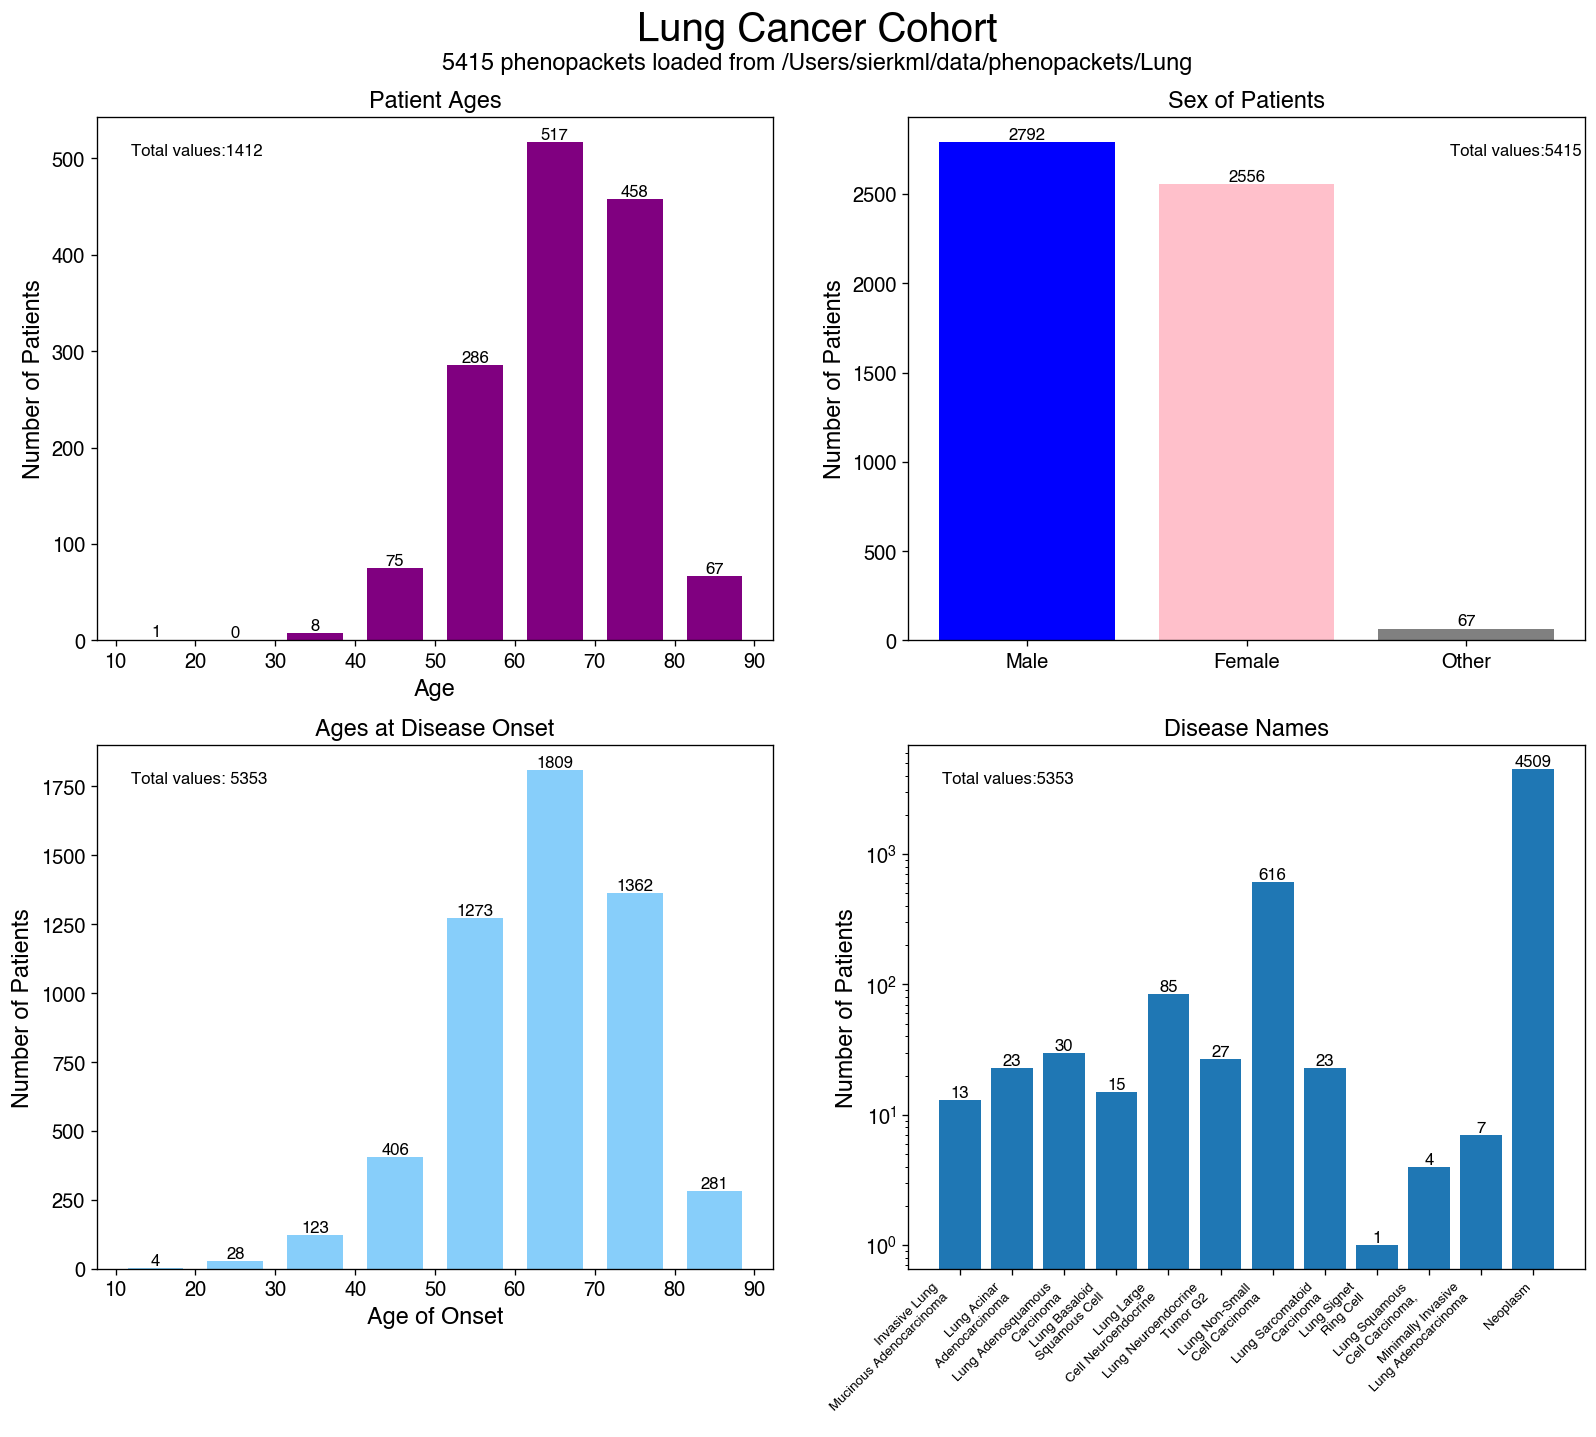

In [214]:
# adjust nrows & ncols for number of plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16), dpi=120)
fig.subplots_adjust(wspace=.2, hspace=.2, top=.9, bottom=.3)

title = cohort + " Cancer Cohort"
plt.text(x=0.5, y=0.94, s=title, fontsize=24, ha="center", transform=fig.transFigure)
subt = str(len(pps)) + " phenopackets loaded from " + fpath_cohort_dir
plt.text(x=0.5, y=0.925, s=subt, fontsize=14, ha="center", transform=fig.transFigure)

# plot 1-6 of the following:
generate_age_barplot(pps, axs[0,0])
generate_sex_barplot(pps, axs[0, 1])
generate_onset_barplot(pps, axs[1, 0])
generate_diseases_barplot(pps, axs[1, 1])
#generate_stages_barplot(pps, axs[2, 0])
#generate_diagnosis_site_barplot(pps, axs[2, 1])


plt.savefig("lung_cancer_cohort.png", dpi=300)

### Try out widgets 

In [205]:
from ipywidgets import Button

b3 = Button(description='Styled button', 
            style=dict(
                    font_style='italic',
                    font_weight='bold',
                    font_variant="small-caps",
                    text_color='red',
                    text_decoration='underline'
            )
)
b3.style.button_color = 'lightgreen'
b3.style.font_style='italic'
b3.style.font_size = '20'

b3

Button(description='Styled button', style=ButtonStyle(button_color='lightgreen', font_size='20', font_style='i…

In [206]:
widgets.HBox([widgets.Label(value="The $m$ in $E=mc^2$:"), widgets.FloatSlider()])

In [207]:
import ipywidgets as widgets

menu = widgets.SelectMultiple(
        options=['Age', 'Sex', 'Onset', 'Diseases', 'Stages', 'Sites'],
        value=[],
        rows=6,
        description='Fields:',
        disabled=False,
        layout={'width': 'max-content'},
        style=dict(font_size=20)
        )
menu.style.font_size = 14

widgets.Box(
    [
        #widgets.Label(value="Select data to plot (hold command or control to select multiple)"), 
        menu
    ]
)
#menu

Box(children=(SelectMultiple(description='Fields:', layout=Layout(width='max-content'), options=('Age', 'Sex',…